# Section 2: Domain Analysis and Data Preparation

## Fashion Rental Recommendation System

This notebook implements the domain analysis and data preparation phase for an Intelligent Recommendation System (IRS) project using the **Rent the Runway** dataset.

---
## Part 1: Domain Background and Requirements

### 1.1 Domain Background

**Fashion Rental E-Commerce** is a rapidly growing industry where consumers rent clothing items for specific occasions rather than purchasing them outright. This business model appeals to fashion-conscious consumers who want access to high-end designer pieces without the commitment of ownership.

**Current Recommendation Approaches in Fashion Rental:**
- **Collaborative Filtering**: Leveraging user-item rating matrices to find similar users/items and make recommendations based on past rental behavior
- **Content-Based Filtering**: Using item metadata (category, style, designer) and user attributes (body measurements, preferences) to match users with appropriate items
- **Hybrid Systems**: Combining collaborative and content-based approaches to overcome individual limitations

**Proposed System Focus:**
Our recommendation system will be a **hybrid approach** that uniquely leverages:
1. User-item interaction data (ratings, rental history)
2. Rich user body attributes (height, weight, bust size, body type)
3. Item content features (category, occasion suitability)
4. Textual review content for sentiment and fit analysis

**Target Users:**
- Fashion-conscious consumers seeking personalized clothing recommendations
- Users with specific body types who need fit-appropriate suggestions
- Occasional renters (weddings, parties, formal events) seeking occasion-specific recommendations

### 1.2 Key Domain Challenges

We identify three key challenges specific to the fashion rental domain:

1. **Cold-Start Problem**: New users without rental history and new items without ratings pose significant challenges. In fashion, this is particularly critical because fit recommendations depend heavily on personal body characteristics that only emerge through interaction history.

2. **Data Sparsity**: With thousands of items and users, the user-item rating matrix is extremely sparse. Fashion rental exacerbates this because users typically rent for special occasions (infrequent purchases), leading to fewer data points per user.

3. **Personalization Complexity**: Fashion recommendations must account for multiple factors beyond simple preference matching:
   - Physical fit based on body measurements
   - Style preferences 
   - Occasion context (wedding vs. casual party)
   - Temporal factors (seasonal appropriateness)

---
## Part 2: Dataset Preparation

### 2.1 Import Libraries and Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the Rent the Runway dataset
data_path = 'dataset/renttherunway_final_data.json'

# Read JSON lines file
records = []
with open(data_path, 'r') as f:
    for line in f:
        records.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(records)

print(f"Dataset loaded successfully!")
print(f"Total records: {len(df):,}")
print(f"\nColumns: {list(df.columns)}")

Dataset loaded successfully!
Total records: 192,544

Columns: ['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating', 'rented for', 'review_text', 'body type', 'review_summary', 'category', 'height', 'size', 'age', 'review_date']


In [3]:
# Display first few records
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


In [4]:
# Display data types and basic info
print("Dataset Info:")
print("=" * 50)
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   fit             192544 non-null  object
 1   user_id         192544 non-null  object
 2   bust size       174133 non-null  object
 3   item_id         192544 non-null  object
 4   weight          162562 non-null  object
 5   rating          192462 non-null  object
 6   rented for      192534 non-null  object
 7   review_text     192544 non-null  object
 8   body type       177907 non-null  object
 9   review_summary  192544 non-null  object
 10  category        192544 non-null  object
 11  height          191867 non-null  object
 12  size            192544 non-null  int64 
 13  age             191584 non-null  object
 14  review_date     192544 non-null  object
dtypes: int64(1), object(14)
memory usage: 22.0+ MB


### 2.2 Data Preprocessing

#### 2.2.1 Handle Missing Values

Missing Values Analysis:
            Missing Count  Missing Percentage (%)
weight              29982                   15.57
bust size           18411                    9.56
body type           14637                    7.60
age                   960                    0.50
height                677                    0.35
rating                 82                    0.04
rented for             10                    0.01


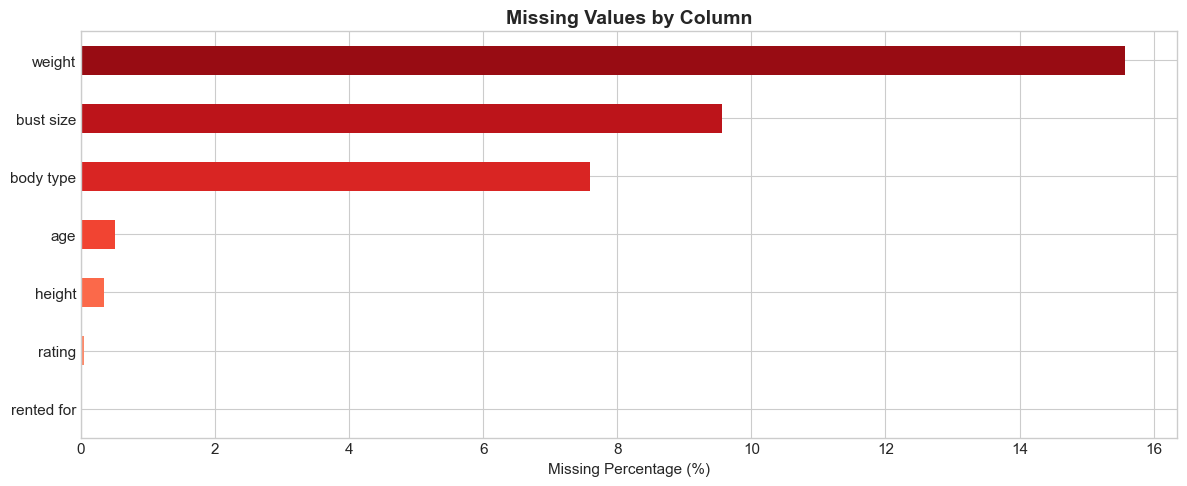

In [5]:
# Check for missing values
missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage (%)': missing_percentages
})

print("Missing Values Analysis:")
print("=" * 50)
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

# Visualize missing values
plt.figure(figsize=(12, 5))
missing_pct = missing_df[missing_df['Missing Count'] > 0]['Missing Percentage (%)'].sort_values(ascending=True)
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(missing_pct)))
missing_pct.plot(kind='barh', color=colors)
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# Handle missing values for core columns (user_id, item_id, rating)
# These are essential for recommendation systems

core_columns = ['user_id', 'item_id', 'rating']
print("Missing values in core columns:")
print(df[core_columns].isnull().sum())

# Drop rows with missing core values
initial_count = len(df)
df = df.dropna(subset=core_columns)
print(f"\nRemoved {initial_count - len(df)} rows with missing core values")
print(f"Remaining records: {len(df):,}")

Missing values in core columns:
user_id     0
item_id     0
rating     82
dtype: int64

Removed 82 rows with missing core values
Remaining records: 192,462


#### 2.2.2 Handle Duplicates

In [7]:
# Check for duplicate records
print("Duplicate Analysis:")
print("=" * 50)

# Full duplicates
full_duplicates = df.duplicated().sum()
print(f"Full duplicate rows: {full_duplicates}")

# Duplicates based on user-item pairs
user_item_duplicates = df.duplicated(subset=['user_id', 'item_id']).sum()
print(f"Duplicate user-item pairs: {user_item_duplicates}")

# Remove duplicate user-item interactions (keep first)
if user_item_duplicates > 0:
    df = df.drop_duplicates(subset=['user_id', 'item_id'], keep='first')
    print(f"\nAfter removing duplicates: {len(df):,} records")

Duplicate Analysis:
Full duplicate rows: 188
Duplicate user-item pairs: 264

After removing duplicates: 192,198 records


#### 2.2.3 Scale Ratings to 1-5 Range

In [8]:
# Convert rating to numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Check original rating range
print("Original Rating Statistics:")
print("=" * 50)
print(f"Min rating: {df['rating'].min()}")
print(f"Max rating: {df['rating'].max()}")
print(f"Mean rating: {df['rating'].mean():.2f}")
print(f"\nOriginal rating distribution:")
print(df['rating'].value_counts().sort_index())

Original Rating Statistics:
Min rating: 2
Max rating: 10
Mean rating: 9.09

Original rating distribution:
rating
2       1046
4       2787
6      10687
8      53325
10    124353
Name: count, dtype: int64


In [9]:
# Scale ratings from 1-10 to 1-5
# Formula: rating_1_5 = (rating - 1) * (4/9) + 1
# This maps 1 -> 1 and 10 -> 5

def scale_rating(rating, old_min=1, old_max=10, new_min=1, new_max=5):
    """Scale rating from old range to new range."""
    return ((rating - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

df['rating_scaled'] = df['rating'].apply(scale_rating)

print("Scaled Rating Statistics (1-5 range):")
print("=" * 50)
print(f"Min rating: {df['rating_scaled'].min():.2f}")
print(f"Max rating: {df['rating_scaled'].max():.2f}")
print(f"Mean rating: {df['rating_scaled'].mean():.2f}")
print(f"Std rating: {df['rating_scaled'].std():.2f}")

Scaled Rating Statistics (1-5 range):
Min rating: 1.44
Max rating: 5.00
Mean rating: 4.60
Std rating: 0.64


#### 2.2.4 Extract Basic Statistics

In [10]:
# Calculate key statistics
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_ratings = len(df)

# Calculate sparsity
# Sparsity = 1 - (number of ratings / (number of users * number of items))
possible_ratings = n_users * n_items
sparsity = 1 - (n_ratings / possible_ratings)

# Rating density
density = n_ratings / possible_ratings

# Average ratings per user and per item
avg_ratings_per_user = n_ratings / n_users
avg_ratings_per_item = n_ratings / n_items

print("="*60)
print("            DATASET STATISTICS SUMMARY")
print("="*60)
print(f"{'Metric':<35} {'Value':>20}")
print("-"*60)
print(f"{'Number of Users:':<35} {n_users:>20,}")
print(f"{'Number of Items:':<35} {n_items:>20,}")
print(f"{'Number of Ratings:':<35} {n_ratings:>20,}")
print(f"{'Possible User-Item Pairs:':<35} {possible_ratings:>20,}")
print("-"*60)
print(f"{'Sparsity Level:':<35} {sparsity*100:>19.4f}%")
print(f"{'Density:':<35} {density*100:>19.6f}%")
print("-"*60)
print(f"{'Avg Ratings per User:':<35} {avg_ratings_per_user:>20.2f}")
print(f"{'Avg Ratings per Item:':<35} {avg_ratings_per_item:>20.2f}")
print("="*60)

# Verify minimum requirements
print("\n✓ Dataset Requirements Check:")
print(f"  Users >= 5,000: {n_users:,} {'✓ PASS' if n_users >= 5000 else '✗ FAIL'}")
print(f"  Items >= 500: {n_items:,} {'✓ PASS' if n_items >= 500 else '✗ FAIL'}")
print(f"  Ratings >= 50,000: {n_ratings:,} {'✓ PASS' if n_ratings >= 50000 else '✗ FAIL'}")

            DATASET STATISTICS SUMMARY
Metric                                             Value
------------------------------------------------------------
Number of Users:                                 105,508
Number of Items:                                   5,850
Number of Ratings:                               192,198
Possible User-Item Pairs:                    617,221,800
------------------------------------------------------------
Sparsity Level:                                 99.9689%
Density:                                       0.031139%
------------------------------------------------------------
Avg Ratings per User:                               1.82
Avg Ratings per Item:                              32.85

✓ Dataset Requirements Check:
  Users >= 5,000: 105,508 ✓ PASS
  Items >= 500: 5,850 ✓ PASS
  Ratings >= 50,000: 192,198 ✓ PASS


---
## Part 3: Basic Exploratory Analysis

### 3.1 Rating Distribution

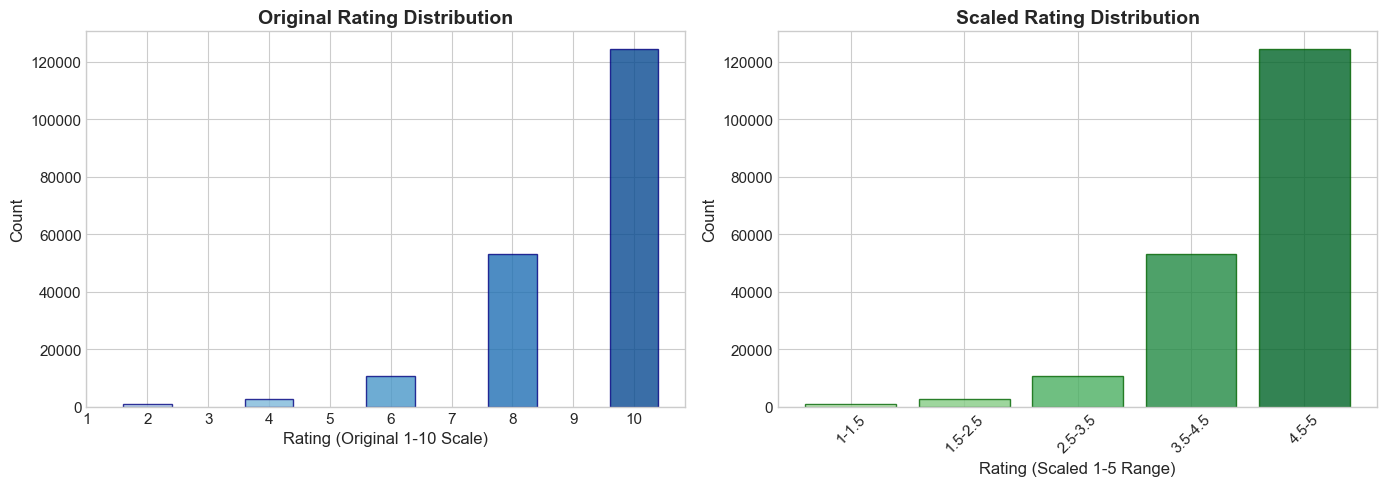


Observation: The rating distribution is highly skewed towards positive ratings (8-10),
indicating users predominantly leave reviews when satisfied with their rental.


In [11]:
# Rating distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original ratings (1-10)
rating_counts = df['rating'].value_counts().sort_index()
colors1 = plt.cm.Blues(np.linspace(0.3, 0.9, len(rating_counts)))
axes[0].bar(rating_counts.index, rating_counts.values, color=colors1, edgecolor='navy', alpha=0.8)
axes[0].set_xlabel('Rating (Original 1-10 Scale)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Original Rating Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 11))

# Scaled ratings (1-5) - binned
bins = [1, 1.5, 2.5, 3.5, 4.5, 5.01]
labels = ['1-1.5', '1.5-2.5', '2.5-3.5', '3.5-4.5', '4.5-5']
df['rating_bin'] = pd.cut(df['rating_scaled'], bins=bins, labels=labels, include_lowest=True)
bin_counts = df['rating_bin'].value_counts().sort_index()
colors2 = plt.cm.Greens(np.linspace(0.3, 0.9, len(bin_counts)))
axes[1].bar(range(len(bin_counts)), bin_counts.values, color=colors2, edgecolor='darkgreen', alpha=0.8)
axes[1].set_xlabel('Rating (Scaled 1-5 Range)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Scaled Rating Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(bin_counts)))
axes[1].set_xticklabels(labels, rotation=45)

plt.tight_layout()
plt.savefig('rating_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nObservation: The rating distribution is highly skewed towards positive ratings (8-10),")
print("indicating users predominantly leave reviews when satisfied with their rental.")

### 3.2 User Activity Distribution

User Activity Statistics:
count    105508.000000
mean          1.821644
std           3.032824
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         407.000000
dtype: float64


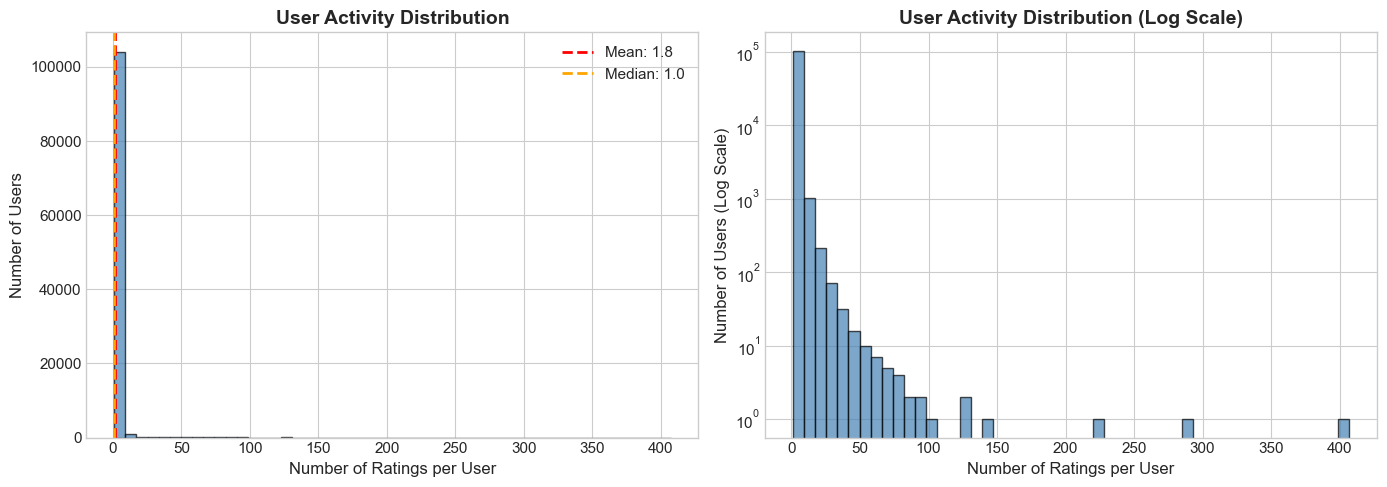


User Activity Breakdown:
  Users with 1 rating: 71,830 (68.1%)
  Users with 2-5 ratings: 29,748
  Users with 6-10 ratings: 2,806
  Users with >10 ratings: 1,124


In [12]:
# Calculate ratings per user
user_activity = df.groupby('user_id').size()

print("User Activity Statistics:")
print("=" * 50)
print(user_activity.describe())

# Visualize user activity distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of user activity
axes[0].hist(user_activity, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Ratings per User', fontsize=12)
axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].set_title('User Activity Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(user_activity.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {user_activity.mean():.1f}')
axes[0].axvline(user_activity.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {user_activity.median():.1f}')
axes[0].legend()

# Log-scale histogram for better visualization of distribution tail
axes[1].hist(user_activity, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Ratings per User', fontsize=12)
axes[1].set_ylabel('Number of Users (Log Scale)', fontsize=12)
axes[1].set_title('User Activity Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('user_activity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# User activity breakdown
print("\nUser Activity Breakdown:")
print(f"  Users with 1 rating: {(user_activity == 1).sum():,} ({(user_activity == 1).sum()/len(user_activity)*100:.1f}%)")
print(f"  Users with 2-5 ratings: {((user_activity >= 2) & (user_activity <= 5)).sum():,}")
print(f"  Users with 6-10 ratings: {((user_activity >= 6) & (user_activity <= 10)).sum():,}")
print(f"  Users with >10 ratings: {(user_activity > 10).sum():,}")

### 3.3 Item Popularity Distribution

Item Popularity Statistics:
count    5850.000000
mean       32.854359
std        84.838493
min         1.000000
25%         5.000000
50%        14.000000
75%        32.000000
max      2229.000000
dtype: float64


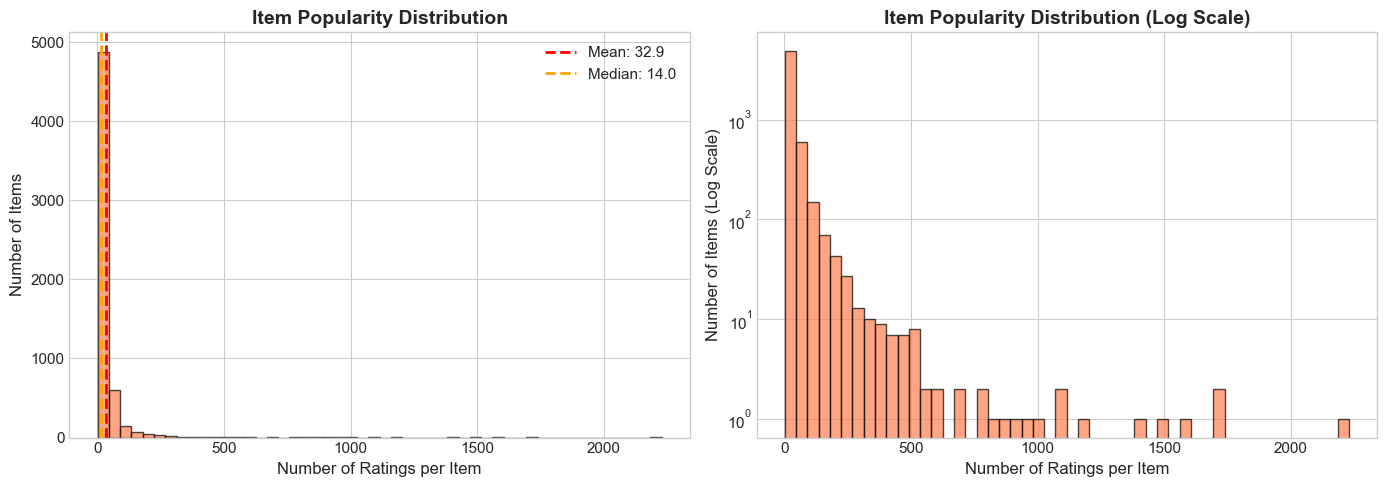


Item Popularity Breakdown:
  Items with 1 rating: 341 (5.8%)
  Items with 2-5 ratings: 1,162
  Items with 6-20 ratings: 2,119
  Items with >20 ratings: 2,228


In [13]:
# Calculate ratings per item
item_popularity = df.groupby('item_id').size()

print("Item Popularity Statistics:")
print("=" * 50)
print(item_popularity.describe())

# Visualize item popularity distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of item popularity
axes[0].hist(item_popularity, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Ratings per Item', fontsize=12)
axes[0].set_ylabel('Number of Items', fontsize=12)
axes[0].set_title('Item Popularity Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(item_popularity.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {item_popularity.mean():.1f}')
axes[0].axvline(item_popularity.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {item_popularity.median():.1f}')
axes[0].legend()

# Log-scale histogram
axes[1].hist(item_popularity, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Ratings per Item', fontsize=12)
axes[1].set_ylabel('Number of Items (Log Scale)', fontsize=12)
axes[1].set_title('Item Popularity Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('item_popularity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Item popularity breakdown
print("\nItem Popularity Breakdown:")
print(f"  Items with 1 rating: {(item_popularity == 1).sum():,} ({(item_popularity == 1).sum()/len(item_popularity)*100:.1f}%)")
print(f"  Items with 2-5 ratings: {((item_popularity >= 2) & (item_popularity <= 5)).sum():,}")
print(f"  Items with 6-20 ratings: {((item_popularity >= 6) & (item_popularity <= 20)).sum():,}")
print(f"  Items with >20 ratings: {(item_popularity > 20).sum():,}")

### 3.4 Long-Tail Analysis

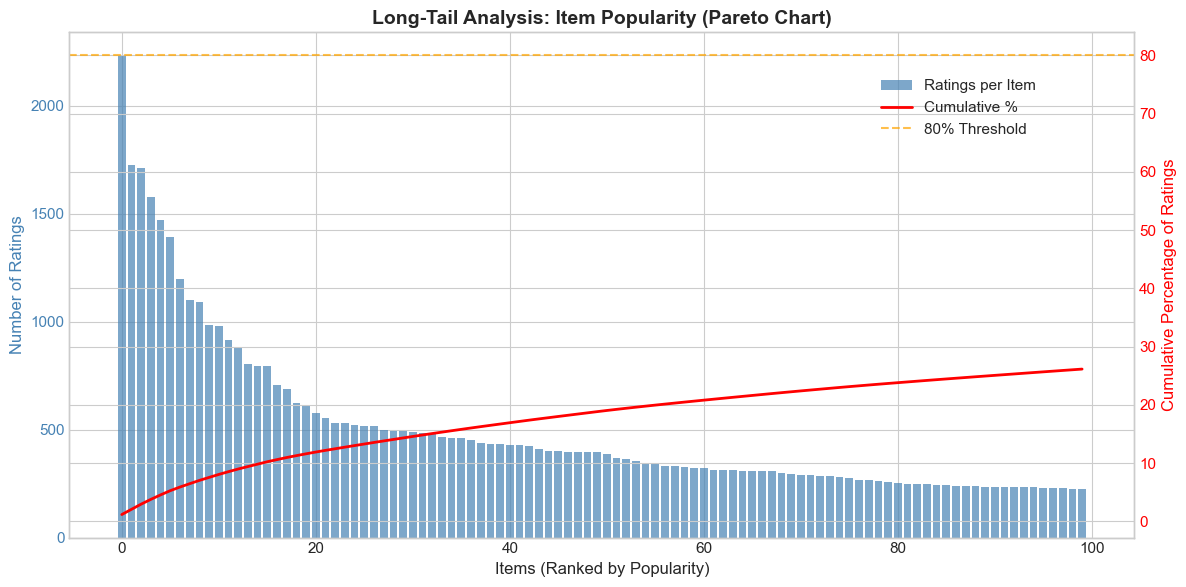


            LONG-TAIL ANALYSIS RESULTS
Metric                                               Value
------------------------------------------------------------
% of items accounting for 50% of ratings:            8.26%
% of items accounting for 80% of ratings:           31.33%
% of items accounting for 90% of ratings:           47.88%

✓ Distribution is relatively balanced across items.


In [14]:
# Long-tail analysis for items (Pareto analysis)
# Sort items by popularity
item_popularity_sorted = item_popularity.sort_values(ascending=False)

# Calculate cumulative percentage of ratings
cumulative_ratings = item_popularity_sorted.cumsum() / item_popularity_sorted.sum() * 100

# Calculate percentage of items
item_percentages = np.arange(1, len(item_popularity_sorted) + 1) / len(item_popularity_sorted) * 100

# Find key thresholds
items_for_50_ratings = (cumulative_ratings < 50).sum() / len(cumulative_ratings) * 100
items_for_80_ratings = (cumulative_ratings < 80).sum() / len(cumulative_ratings) * 100
items_for_90_ratings = (cumulative_ratings < 90).sum() / len(cumulative_ratings) * 100

# Pareto Chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for item ratings
n_display = min(100, len(item_popularity_sorted))  # Show top 100 items
bars = ax1.bar(range(n_display), item_popularity_sorted.values[:n_display], 
               color='steelblue', alpha=0.7, label='Ratings per Item')
ax1.set_xlabel('Items (Ranked by Popularity)', fontsize=12)
ax1.set_ylabel('Number of Ratings', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Cumulative line
ax2 = ax1.twinx()
ax2.plot(range(n_display), cumulative_ratings.values[:n_display], 
         color='red', linewidth=2, label='Cumulative %')
ax2.set_ylabel('Cumulative Percentage of Ratings', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80% Threshold')

plt.title('Long-Tail Analysis: Item Popularity (Pareto Chart)', fontsize=14, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))
plt.tight_layout()
plt.savefig('longtail_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("            LONG-TAIL ANALYSIS RESULTS")
print("="*60)
print(f"{'Metric':<45} {'Value':>12}")
print("-"*60)
print(f"{'% of items accounting for 50% of ratings:':<45} {items_for_50_ratings:>11.2f}%")
print(f"{'% of items accounting for 80% of ratings:':<45} {items_for_80_ratings:>11.2f}%")
print(f"{'% of items accounting for 90% of ratings:':<45} {items_for_90_ratings:>11.2f}%")
print("="*60)

# Interpretation
if items_for_80_ratings < 30:
    print("\n⚠️  LONG-TAIL PROBLEM DETECTED")
    print(f"   A small fraction ({items_for_80_ratings:.1f}%) of items receives 80% of all ratings.")
    print("   This indicates a severe popularity bias that can affect recommendation quality.")
else:
    print("\n✓ Distribution is relatively balanced across items.")

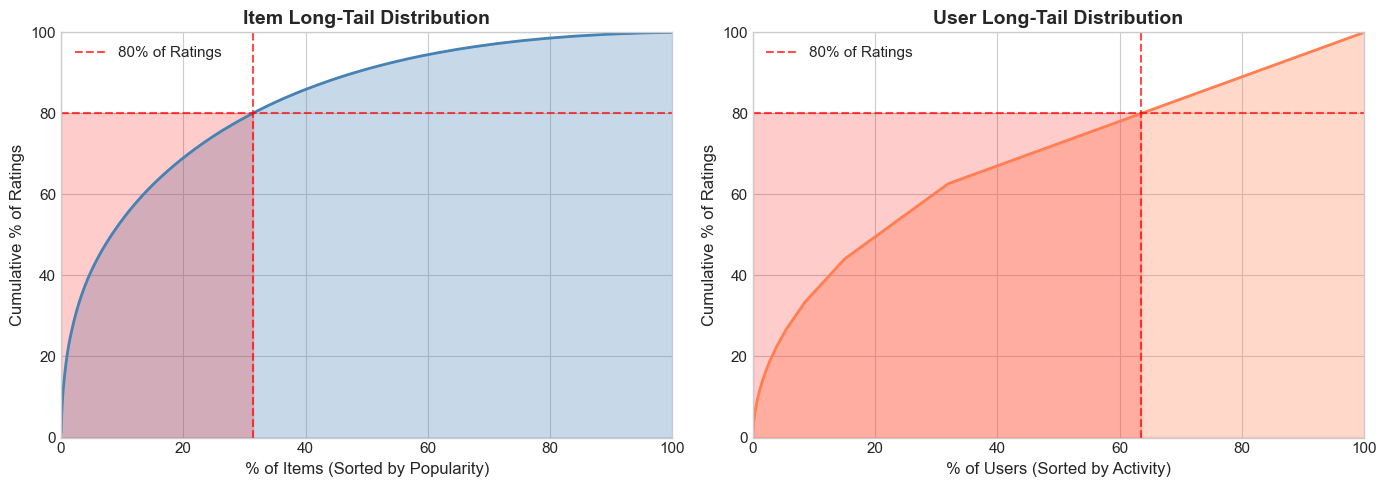


User Long-Tail: 63.6% of users account for 80% of ratings
Item Long-Tail: 31.3% of items account for 80% of ratings


In [15]:
# Long-tail visualization for users as well
user_activity_sorted = user_activity.sort_values(ascending=False)
cumulative_user_ratings = user_activity_sorted.cumsum() / user_activity_sorted.sum() * 100

# Key thresholds for users
users_for_50_ratings = (cumulative_user_ratings < 50).sum() / len(cumulative_user_ratings) * 100
users_for_80_ratings = (cumulative_user_ratings < 80).sum() / len(cumulative_user_ratings) * 100

# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Items long-tail
axes[0].fill_between(item_percentages, cumulative_ratings.values, alpha=0.3, color='steelblue')
axes[0].plot(item_percentages, cumulative_ratings.values, color='steelblue', linewidth=2)
axes[0].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% of Ratings')
axes[0].axvline(x=items_for_80_ratings, color='red', linestyle='--', alpha=0.7)
axes[0].fill_between([0, items_for_80_ratings], [0, 0], [80, 80], alpha=0.2, color='red')
axes[0].set_xlabel('% of Items (Sorted by Popularity)', fontsize=12)
axes[0].set_ylabel('Cumulative % of Ratings', fontsize=12)
axes[0].set_title('Item Long-Tail Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)

# Users long-tail  
user_percentages = np.arange(1, len(user_activity_sorted) + 1) / len(user_activity_sorted) * 100
axes[1].fill_between(user_percentages, cumulative_user_ratings.values, alpha=0.3, color='coral')
axes[1].plot(user_percentages, cumulative_user_ratings.values, color='coral', linewidth=2)
axes[1].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% of Ratings')
axes[1].axvline(x=users_for_80_ratings, color='red', linestyle='--', alpha=0.7)
axes[1].fill_between([0, users_for_80_ratings], [0, 0], [80, 80], alpha=0.2, color='red')
axes[1].set_xlabel('% of Users (Sorted by Activity)', fontsize=12)
axes[1].set_ylabel('Cumulative % of Ratings', fontsize=12)
axes[1].set_title('User Long-Tail Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.savefig('longtail_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nUser Long-Tail: {users_for_80_ratings:.1f}% of users account for 80% of ratings")
print(f"Item Long-Tail: {items_for_80_ratings:.1f}% of items account for 80% of ratings")

### 3.5 Content Feature Analysis

In [16]:
# Analyze content features for content-based filtering
print("Content Feature Analysis:")
print("="*60)

# Categories
if 'category' in df.columns:
    print(f"\n📦 Item Categories: {df['category'].nunique()} unique categories")
    print(df['category'].value_counts().head(10))

# Occasions (rented for)
if 'rented for' in df.columns:
    print(f"\n🎉 Rental Occasions: {df['rented for'].nunique()} unique occasions")
    print(df['rented for'].value_counts())

Content Feature Analysis:

📦 Item Categories: 68 unique categories
category
dress       92674
gown        44323
sheath      19256
shift        5360
jumpsuit     5181
top          4928
maxi         3441
romper       3067
jacket       2404
mini         1751
Name: count, dtype: int64

🎉 Rental Occasions: 9 unique occasions
rented for
wedding            57704
formal affair      40329
party              35551
everyday           16798
other              15353
work               15017
date                7379
vacation            4056
party: cocktail        1
Name: count, dtype: int64


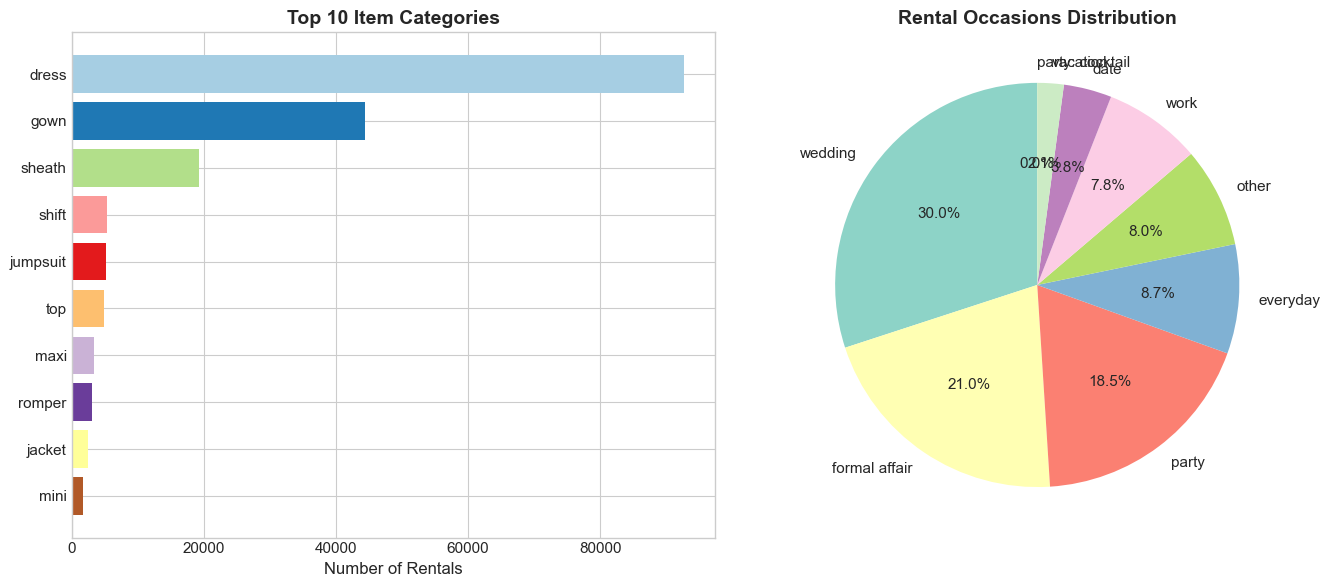

In [17]:
# Visualize category and occasion distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Categories
if 'category' in df.columns:
    category_counts = df['category'].value_counts().head(10)
    colors = plt.cm.Paired(np.linspace(0, 1, len(category_counts)))
    axes[0].barh(range(len(category_counts)), category_counts.values, color=colors)
    axes[0].set_yticks(range(len(category_counts)))
    axes[0].set_yticklabels(category_counts.index)
    axes[0].set_xlabel('Number of Rentals', fontsize=12)
    axes[0].set_title('Top 10 Item Categories', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()

# Occasions
if 'rented for' in df.columns:
    occasion_counts = df['rented for'].value_counts()
    colors2 = plt.cm.Set3(np.linspace(0, 1, len(occasion_counts)))
    axes[1].pie(occasion_counts.values, labels=occasion_counts.index, autopct='%1.1f%%',
                colors=colors2, startangle=90)
    axes[1].set_title('Rental Occasions Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('content_features.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Summary and Conclusions

In [18]:
# Final summary
print("="*70)
print("              SECTION 2: ANALYSIS SUMMARY")
print("="*70)

print("\n📊 DATASET OVERVIEW")
print("-"*50)
print(f"  • Dataset: Rent the Runway Fashion Rental Reviews")
print(f"  • Total Records: {len(df):,}")
print(f"  • Unique Users: {n_users:,}")
print(f"  • Unique Items: {n_items:,}")
print(f"  • Sparsity Level: {sparsity*100:.2f}%")

print("\n✓ REQUIREMENTS VERIFICATION")
print("-"*50)
requirements = [
    ("Users ≥ 5,000", n_users >= 5000, f"{n_users:,}"),
    ("Items ≥ 500", n_items >= 500, f"{n_items:,}"),
    ("Ratings ≥ 50,000", n_ratings >= 50000, f"{n_ratings:,}"),
    ("Content Features", True, "Categories, Occasions, Reviews")
]
for req, passed, value in requirements:
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"  {req:<25} {status:<10} ({value})")

print("\n📈 KEY FINDINGS")
print("-"*50)
print(f"  • Long-tail problem exists: {items_for_80_ratings:.1f}% items = 80% ratings")
print(f"  • High data sparsity: {sparsity*100:.2f}%")
print(f"  • Rating bias: Distribution skewed toward positive ratings")
print(f"  • Average user activity: {avg_ratings_per_user:.1f} ratings/user")
print(f"  • Average item popularity: {avg_ratings_per_item:.1f} ratings/item")

print("\n🎯 IMPLICATIONS FOR RECOMMENDATION SYSTEM")
print("-"*50)
print("  • Cold-start handling essential for new users/items")
print("  • Consider hybrid approach to address sparsity")
print("  • Content features (body type, occasion) valuable for filtering")
print("  • Address popularity bias in evaluation metrics")

print("\n" + "="*70)

              SECTION 2: ANALYSIS SUMMARY

📊 DATASET OVERVIEW
--------------------------------------------------
  • Dataset: Rent the Runway Fashion Rental Reviews
  • Total Records: 192,198
  • Unique Users: 105,508
  • Unique Items: 5,850
  • Sparsity Level: 99.97%

✓ REQUIREMENTS VERIFICATION
--------------------------------------------------
  Users ≥ 5,000             ✓ PASS     (105,508)
  Items ≥ 500               ✓ PASS     (5,850)
  Ratings ≥ 50,000          ✓ PASS     (192,198)
  Content Features          ✓ PASS     (Categories, Occasions, Reviews)

📈 KEY FINDINGS
--------------------------------------------------
  • Long-tail problem exists: 31.3% items = 80% ratings
  • High data sparsity: 99.97%
  • Rating bias: Distribution skewed toward positive ratings
  • Average user activity: 1.8 ratings/user
  • Average item popularity: 32.9 ratings/item

🎯 IMPLICATIONS FOR RECOMMENDATION SYSTEM
--------------------------------------------------
  • Cold-start handling essential f

In [19]:
# Save preprocessed data for next sections
output_path = 'dataset/preprocessed_data.csv'
df.to_csv(output_path, index=False)
print(f"Preprocessed data saved to: {output_path}")
print(f"Shape: {df.shape}")

Preprocessed data saved to: dataset/preprocessed_data.csv
Shape: (192198, 17)
